In [96]:
import os, random, re, math, json
from tqdm import tqdm
from scipy.stats import iqr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from matplotlib.pyplot import figure

### DeepFD

In [97]:
subject_list = [
    "31880720",    
    "41600519",
    "45442843",
    "48385830",
    "48594888",
    "50306988",
    "51181393",
    "56380303",
    "59325381"
]

algos = ["random", "hebo", "bohb"]
times = [10, 20, 50]

In [98]:
def get_op_sol(x):
    if x in ["selu", "relu", "tanh"]:
        return ["act", "ki"]
    if x in ["leaky"]:
        return ["act"]
    if x in ["bn"]:
        return None
    if x in ["optimizer", "momentum", "gradient"]:
        return ["optimizer"]
    if x == "initial":
        return ["ki", "bi"]
    if x in ["lr", "ReduceLR"]:
        return ["lr"]
    if x == "GN":
        return ["kr"]

def get_val_sol(x, desc):
    if x in ["selu", "relu", "tanh"]:        
        res = re.findall(r"\'(\w+)\'", desc)        
        return [x, res[1]]
    if x in ["leaky"]:            
        return [x]
    if x in ["bn"]:
        return None
    if x in ["optimizer"]:
        return ["sgd"]
    if x in ["momentum", "gradient"]:
        return [None]
    if x == "initial":
        res = re.findall(r"\'(\w+)\'", desc)
        return [res[0], res[1]]
    if x in ["lr"]:        
        res = re.findall(r"\'([\w\d\-.]+)\'", desc)        
        return [float(res[0])]
    if x == "ReduceLR":
        return [None]
    if x == "GN":
        return [None]

AutoTrainer_log_home = "/home/hpo/data/saved_logs/"
at_patch_ops = {}

# selu ["Using 'SeLU' activation in each layers' activations; Use 'lecun_uniform' as the kernel initializer."]
# relu ["Using 'ReLU' activation in each layers' activations; Use 'he_uniform' as the kernel initializer."]
# tanh ["Using 'tanh' activation in each layers' activation; Use 'he_uniform' as the kernel initializer."]

# leaky ["Using advanced activation '{}' instead of each layers' activations."]

# bn ["Using 'BatchNormalization' layers after each Dense layers in the model."]

# optimizer ['Using Nadam optimizer in model training', ' the parameter setting is default.']
# momentum ["Using 'momentum 0.27' in SGD optimizer in the optimizer."]
# gradient ["Using 'Gradient Clip' operation", ' add clipvalue=9.82 to the optimizer']

# initial ["Using 'glorot_uniform' initializer as each layers' kernel initializer;         Use 'glorot_uniform' initializer as each layers' bias initializer."]

# lr ["Using '9.999999850988392e-05' learning rate in the optimizer."]
# ReduceLR ["Using 'ReduceLROnPlateau' callbacks in training."]

# GN ["Using 'Gaussian_Noise' after the input layer."]

for _file in os.listdir(AutoTrainer_log_home):
    pnum = _file.split(".")[0]
    if "reuters_change_learning_rate_mutated0_MP_False_1" in pnum:
        pnum += ".0"

    run_num = int(_file.split("_")[-1][:-4])    
    solutions = []
    change_vals = {}
        
    if pnum[-2:] == "_0":
        pnum = pnum[:-2]

    if "origin" in pnum:
        pnum = pnum.split("_")[1]
    else:
        pnum = pnum + ".py"
        
    if pnum not in at_patch_ops:
        at_patch_ops[pnum] = {}

    with open(os.path.join(AutoTrainer_log_home, _file), "r") as f:
        next(f)
        # print(_file)
        for line in f:
            sol = line.strip().split(",")[0]
            desc = " ".join(line.strip().split(",")[4:])
            
            if "------------------" in sol:
                break
            # print(sol, desc)
            _sol = get_op_sol(sol)
            _vals = get_val_sol(sol, desc)
            if _sol is not None:
                for _s, _v in zip(_sol, _vals):
                    if _s not in solutions:
                        solutions.append(_s)
                    if _s not in change_vals:
                        change_vals[_s] = _v
                    if _v is not None:
                        change_vals[_s] = _v

    at_patch_ops[pnum][run_num] = (solutions, change_vals)

In [99]:
at_ops_10_runs = {}
with open("/home/hpo/results/AutoTrainer/deepfd_best_patches.csv", "r") as f:
    for line in f:
        pnum, time, run_nums = line.strip().split("|")
        time = int(time)
        run_nums = eval(run_nums)
        if pnum not in at_ops_10_runs:
            at_ops_10_runs[pnum] = {}
        at_ops_10_runs[pnum][time] = []

        if run_nums is not None:            
            for run_num in run_nums:
                at_ops_10_runs[pnum][time].append(at_patch_ops[pnum][run_num])



In [100]:
def check_results_there(subject_paths):
    cnt = {}
    for path, pnum in subject_paths:
        if pnum not in cnt:
            cnt[pnum] = 0
        cnt[pnum] += 1
    print(cnt)

# Read results
HPO_subjects_path = "/home/hpo/results/DFD/"
subject_paths = []
for dir1 in os.listdir(HPO_subjects_path):
    dir1_path = os.path.join(HPO_subjects_path, dir1)
    if dir1.split("|")[1] in subject_list:
        subject_paths.append([dir1_path, dir1.split("|")[1]])
check_results_there(subject_paths)

# Read origin accuracies
HPO_DFD_orig_acc_path = "/home/hpo/data/DeepFD_orig_holdout_acc.txt"
orig_accs = {}
with open(HPO_DFD_orig_acc_path, "r") as f:
    for line in f:
        pnum, repair_acc = line.strip().split("|")
        if pnum not in orig_accs:
            orig_accs[pnum] = []
        orig_accs[pnum].append(float(repair_acc))
    
    for k, v in orig_accs.items():
        orig_accs[k] = [np.mean(v), np.std(v), iqr(v)]

# Read repaired accuracies
HPO_DFD_repair_path = "/home/hpo/data/DeepFD_repair_holdout_acc.txt"
repaired = {}

with open(HPO_DFD_repair_path, "r") as f:
    for line in f:
        pnum, repair_acc = line.strip().split("|")
        if pnum not in repaired:
            repaired[pnum] = []
        repaired[pnum].append(float(repair_acc))
    
    for k, v in repaired.items():
        repaired[k] = [np.mean(v), np.std(v), iqr(v)]


{'45442843': 90, '31880720': 90, '48594888': 90, '50306988': 90, '56380303': 90, '59325381': 90, '51181393': 90, '41600519': 90, '48385830': 90}


In [103]:


def at_get_complexity(fault, cand):
    complexity = 0
    _cand = {}
    for k, v in fault.items():
        _cand[k] = v
        if k == "optimizer" and "optimizer" in cand:
            _cand[k] = cand["optimizer"]
        if k == "lr" and "lr" in cand:
            _cand[k] = cand["lr"]
        if "ki" in k and "ki" in cand:
            _cand[k] = cand["ki"]
        if "bi" in k and "bi" in cand:
            _cand[k] = cand["bi"]
        if "kr" in k and "kr" in cand:
            _cand[k] = cand["kr"]
        if "act" in k and "act" in cand:
            _cand[k] = cand["act"]

    for k, v in fault.items():
        if "epochs" in k or "batch_size" in k or "unit" in k or "layer" in k:
            v = int(v)
        if "lr" in k:
            v = float(v)
                
        if _cand[k] != v:
            complexity += 1

    return complexity

def get_op(x):
    t = ["act", "batch_size", "epochs", "loss", "lr", "optimizer", "ki", "kr"]
    for _t in t:
        if _t in x:
            return _t
    return None

def at_get_jaccard(fault, orig, cand):
    gt_op = []    
    for k, v in orig.items():
        if "epochs" in k or "batch_size" in k or "unit" in k or "layer" in k:
            v = int(v)
        if "lr" in k:
            v = float(v)
        
        if fault[k] != v:            
            gt_op.append(get_op(k))
                
    gt_op = list(set(gt_op))
    if None in gt_op:
        gt_op.remove(None)
    # print(gt_op, set(cand))
    intersection = list(set(gt_op).intersection(set(cand)))
    # print(f"{k}. GT: {v}, fault: {fault[k]}, cand: {cand[k]}")
    # print("Jaccard: ", len(intersection) / len(gt_op))
    return len(intersection) / len(gt_op)


def get_complexity(orig, cand):
    complexity = 0
    orig_list, cand_list = [], []
    for k, v in orig.items():        
        if "epochs" in k or "batch_size" in k or "unit" in k or "layer" in k:
            v = int(v)
            cand[k] = int(cand[k])
        if "lr" in k:
            v = float(v)
            cand[k] = float(cand[k])

        if cand[k] != v:            
            complexity += 1
        orig_list.append(v)
        cand_list.append(cand[k])

    return complexity


def get_jaccard(fault, gt, cand):
    gt_op, cand_op = [], []    
    for k, v in gt.items():
        if "epochs" in k or "batch_size" in k or "unit" in k or "layer" in k:
            v = int(v)
            cand[k] = int(cand[k])
        if "lr" in k:
            v = float(v)
            cand[k] = float(cand[k])
        
        if fault[k] != v:            
            gt_op.append(get_op(k))
        if cand[k] != v:            
            cand_op.append(get_op(k))
            # if fault[k] != cand[k]:
            #     intersection.append(k)
    gt_op = list(set(gt_op))
    if None in gt_op:
        gt_op.remove(None)    
    cand_op = list(set(cand_op))
    if None in cand_op:
        cand_op.remove(None)

    intersection = list(set(gt_op).intersection(set(cand_op)))
    # print(f"{k}. GT: {v}, fault: {fault[k]}, cand: {cand[k]}")
    # print("Jaccard: ", len(intersection) / len(gt_op))
    return len(intersection) / len(gt_op)



def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()


max_candidate = {}
for path, pnum in subject_paths:
    res = re.search(r"_([a-z]+)_iter_-1_time_([0-9]+)_repeat_([0-9]+)_top10_([0-1+])", path)
    algo, time, repeat, top10 = res.groups()
    key = f"{pnum}|{algo}|{time}|{top10}"


    if int(time) not in times or top10 == "0":
        continue
    

    df = pd.read_csv(path)
    hparams = []
    best_param = {}
    for x in list(df.columns):
        if "config." in x:
            hparams.append(x)    
    orig_row = df.iloc[0]    
    df = df.iloc[1:]
    df = df.reset_index(drop=True)
        
    if "mean_loss" in list(df.columns):
        min_index = df.iloc[df["mean_loss"].idxmin()]
        holdout_metric = min_index["holdout_loss"]
        
        if math.isnan(holdout_metric) or holdout_metric > orig_accs[pnum][0]:
            holdout_metric = orig_accs[pnum][0]
            best_param = None
        else:
            for hp in hparams:
                best_param[hp] = min_index[hp]      

    else:
        max_index = df.iloc[df["mean_accuracy"].idxmax()]
        holdout_metric = max_index["holdout_acc"]
        if math.isnan(holdout_metric) or holdout_metric < orig_accs[pnum][0]:
            holdout_metric = orig_accs[pnum][0]
            best_param = None
        else:
            for hp in hparams:
                best_param[hp] = max_index[hp]

    if key not in max_candidate:
        _orig_params = {}
        for hp in hparams:
            _orig_params[hp] = orig_row[hp]
        max_candidate[key] = [_orig_params]
    max_candidate[key].append(best_param)

orig_params, candidates, complexities_initial, complexities_gt, complexities_initial_gt = {}, {}, {}, {}, {}
jaccard_initial, jaccard_gt, jaccard_initial_gt = {}, {}, {}

for k in sorted(max_candidate):
    pnum, algo, time, top10 = k.split("|")
    time = int(time)

    if pnum not in candidates:
        candidates[pnum] = {}
        for _time in times:
            candidates[pnum][_time] = {}
            for _algo in algos:
                candidates[pnum][_time][_algo] = []
    if pnum not in orig_params:
        orig_params[pnum] = {}
        for _time in times:
            orig_params[pnum][_time] = {}
            for _algo in algos:
                orig_params[pnum][_time][_algo] = []
    if pnum not in complexities_initial:
        complexities_initial[pnum] = {}
        for _time in times:
            complexities_initial[pnum][_time] = {}
            for _algo in algos:
                complexities_initial[pnum][_time][_algo] = []
    if pnum not in complexities_gt:
        complexities_gt[pnum] = {}
        for _time in times:
            complexities_gt[pnum][_time] = {}
            for _algo in algos:
                complexities_gt[pnum][_time][_algo] = [] 
    if pnum not in complexities_initial_gt:
        complexities_initial_gt[pnum] = {}
        for _time in times:
            complexities_initial_gt[pnum][_time] = {}
            for _algo in algos:
                complexities_initial_gt[pnum][_time][_algo] = []        
    if pnum not in jaccard_initial:
        jaccard_initial[pnum] = {}
        for _time in times:
            jaccard_initial[pnum][_time] = {}
            for _algo in algos:
                jaccard_initial[pnum][_time][_algo] = []
    if pnum not in jaccard_gt:
        jaccard_gt[pnum] = {}
        for _time in times:
            jaccard_gt[pnum][_time] = {}
            for _algo in algos:
                jaccard_gt[pnum][_time][_algo] = [] 
    if pnum not in jaccard_initial_gt:
        jaccard_initial_gt[pnum] = {}
        for _time in times:
            jaccard_initial_gt[pnum][_time] = {}
            for _algo in algos:
                jaccard_initial_gt[pnum][_time][_algo] = []     

    orig_params[pnum][time][algo] = max_candidate[k][0]
    candidates[pnum][time][algo] = max_candidate[k][1:]

    complexities_initial[pnum][time][algo] = []
    complexities_gt[pnum][time][algo] = []
    complexities_initial_gt[pnum][time][algo] = []

    jaccard_initial[pnum][time][algo] = []
    jaccard_gt[pnum][time][algo] = []
    jaccard_initial_gt[pnum][time][algo] = []

    with open(f"/home/hpo/DFD/{pnum}/gt.json", "r") as f:
        gt_json = json.load(f)
    with open(f"/home/hpo/DFD/{pnum}/fault.json", "r") as f:
        fault_json = json.load(f)
     
    for _k, _v in gt_json.items():
        if "RandomNormal" in str(max_candidate[k][0][_k]):
            max_candidate[k][0][_k] = "RandomNormal"
        if "RandomNormal" in str(_v):
            gt_json[_k] = "RandomNormal"



    # print(pnum, algo, time)        
    
    complexities_initial_gt[pnum][time][algo].append(get_complexity(max_candidate[k][0], gt_json) / len(max_candidate[k][0]))

    for found in max_candidate[k][1:]:
        if found is not None:
            for _k, _v in gt_json.items():                
                if "RandomNormal" in str(found[_k]):
                    found[_k] = "RandomNormal"

            complexities_initial[pnum][time][algo].append(get_complexity(max_candidate[k][0], found) / len(max_candidate[k][0]))            
            jaccard_gt[pnum][time][algo].append(get_jaccard(fault_json, gt_json, found))
            

    # AutoTrainer
    if algo == "random":
        complexities_initial[pnum][time]["at"] = []
        jaccard_gt[pnum][time]["at"] = []
        if pnum not in at_ops_10_runs:
            continue

        for runs in at_ops_10_runs[pnum][time]:                     
            patch_ops, patch_vals = runs
            complexities_initial[pnum][time]["at"].append(at_get_complexity(fault_json, patch_vals) / len(fault_json))
            jaccard_gt[pnum][time]["at"].append(at_get_jaccard(fault_json, gt_json, patch_ops))
    
    # with open(f"/home/hpo/DFD/{pnum}/gt.json", "w") as f:        
    #     json.dump(max_candidate[k][0], f, default=np_encoder)
        

In [104]:
is_wilc = {}
with open("/home/hpo/data/wilcoxon_list.txt", "r") as f:
    for line in f:
        pnum, time, algo = line.strip().split(" ")
        time = int(time)        
        is_wilc[(pnum, time, algo)] = True 


41600519 20
45442843 20
56380303 20


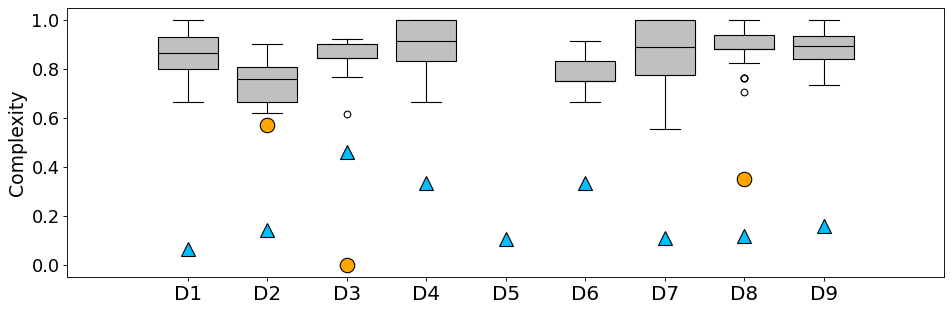

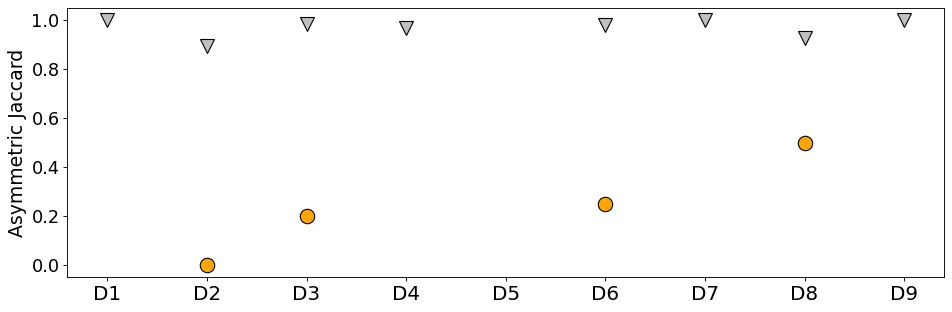

AJ Results - Real faults
HPO, Random:  0.97, 0.11
AutoTrainer:  0.26, 0.19


In [105]:
# Complexity

figure(figsize=(12, 4), dpi=80)

x = 0
w = 0.33
width = 0.25

xticks_name, xticks = [], []
i = 0

for _i, pnum in enumerate(sorted(complexities_initial.keys())):
    merge = []
    for time in [20]:
        for algo in algos:
            if (pnum, time, algo) in is_wilc:                
                merge += complexities_initial[pnum][time][algo]
    if len(merge) == 0:
        pass    
    else:
        bp = plt.boxplot([merge], positions=[x+w*i], widths=width, notch=False, vert=True, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor("silver")
        for median in bp['medians']:
            median.set_color('black')
        

    merge = []
    for time in [20]:
        if (pnum, time, "at") in is_wilc:        
            # print(pnum, time)        
            merge += complexities_initial[pnum][time]["at"]
    if len(merge) == 0:
        pass    
    else:
        print(pnum, time)
        plt.plot(x+w*i, np.mean(merge), "o", color="orange", markeredgecolor= "black", markersize=13)        

    merge = []
    for time in [20]:
        for algo in algos:
            merge += complexities_initial_gt[pnum][time][algo]
    if len(merge) == 0:
        pass    
    else:                
        plt.plot(x+w*i, np.mean(merge), "^", color="deepskyblue", markeredgecolor= "black", markersize=13)
        
    xticks.append(x + w*i)
    xticks_name.append(f"D{_i+1}")
    i += 1

    # for patch in bp['boxes']:
    #     patch.set_facecolor("silver")



plt.xticks(xticks, xticks_name, fontsize=18)

plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)

plt.ylabel("Complexity", fontsize=17)
plt.tight_layout()
plt.savefig(f'/home/hpo/figures/complexity_deepfd.pdf')
plt.show()


# Jaccard
figure(figsize=(12, 4), dpi=80)

x = 0
w = 0.33
width = 0.25
i = 0
at_aj = []
hpo_aj = []
for _i, pnum in enumerate(sorted(jaccard_gt.keys())):
    merge = []
    for time in times:
        if (pnum, time, "at") in is_wilc:
            merge += jaccard_gt[pnum][time]["at"]
                
    if len(merge) == 0:
        pass    
    else:
        # bp = plt.boxplot([merge], positions=[x+w*i], widths=width, notch=False, vert=True, patch_artist=True)
        # for patch in bp['boxes']:
        #     patch.set_facecolor("red")
        plt.plot(x+w*i, np.mean(merge), "o", color="orange", markeredgecolor= "black", markersize=13)        
        # print(pnum, "at", np.mean(merge))
        at_aj += merge

    merge = []
    for time in times:
        for algo in algos:
            if (pnum, time, algo) in is_wilc:
                merge += jaccard_gt[pnum][time][algo]
                
    if len(merge) == 0:
        pass    
    else:
        # bp = plt.boxplot([merge], positions=[x+w*i], widths=width, notch=False, vert=True, patch_artist=True)
        plt.plot(x+w*i, np.mean(merge), "v", color="silver", markeredgecolor= "black", markersize=13)        
        # for patch in bp['boxes']:
        #     patch.set_facecolor("silver")        
        # print(pnum, "HPO/Random", np.mean(merge))
        hpo_aj += merge
    i += 1


plt.xticks(xticks, xticks_name, fontsize=18)

plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)

plt.ylabel("Asymmetric Jaccard", fontsize=17)
# plt.title(f"Jaccard", fontsize=14)
plt.tight_layout()
plt.savefig(f'/home/hpo/figures/AJ_deepfd.png')
plt.show()

print("AJ Results - Real faults")
print("HPO, Random: ", f"{np.mean(hpo_aj):.2f}, {np.std(hpo_aj):.2f}")
print("AutoTrainer: ", f"{np.mean(at_aj):.2f}, {np.std(at_aj):.2f}")



### DeepCrime

In [79]:
datasets = ["MNIST", "CIFAR", "REUTERS", "UNITY"]
algos = ["random", "hebo", "bohb"]
times = [10, 20, 50]
# repair_files = ["mnist_conv.py", "cifar10_conv.py", "lenet.py", "reuters.py"]
repair_files = {
    "MNIST": "mnist_conv.py",
    "CIFAR": "cifar10_conv.py",
    "UNITY": "lenet.py",
    "REUTERS": "reuters.py"
}

In [80]:
at_ops_10_runs = {}
with open("/home/hpo/results/AutoTrainer/deepcrime_best_patches.csv", "r") as f:
    for line in f:
        pnum, time, run_nums = line.strip().split("|")
        time = int(time)
        run_nums = eval(run_nums)
        if pnum not in at_ops_10_runs:
            at_ops_10_runs[pnum] = {}
        at_ops_10_runs[pnum][time] = []

        if run_nums is not None:            
            for run_num in run_nums:
                at_ops_10_runs[pnum][time].append(at_patch_ops[pnum][run_num])



In [81]:
def check_results_there(subject_paths):
    cnt = {}
    for path, pnum in subject_paths:
        res = re.search(r"_([a-z]+)_iter_-1_time_([0-9]+)_repeat_([0-9]+)_top10_([0-1+])", path)
        algo, time, repeat, top10 = res.groups()
        time = int(time)
        #
        if time not in times or algo not in algos or top10 != "1":
            continue
        #
                
        if pnum not in cnt:
            cnt[pnum] = 0
        cnt[pnum] += 1
    print(cnt)
    return cnt

subject_paths = []
for dataset in datasets:
    # Read results
    HPO_subjects_path = f"/home/hpo/results/{dataset}"
    
    _subject_paths = []
    for dir1 in os.listdir(HPO_subjects_path):
        dir1_path = os.path.join(HPO_subjects_path, dir1)
        _subject_paths.append([dir1_path, dir1.split("|")[1]])
    cnt_check = check_results_there(_subject_paths)
    for k, v in cnt_check.items():
        # print(k, v)
        if v in [45, 90]:
            for _sp, _sm in _subject_paths:
                if _sm == k:
                    subject_paths.append([_sp, k])
# print(subject_paths)
# Read origin and repaired accuracies
HPO_DC_orig_acc_path = "/home/hpo/data/DC_orig_holdout_acc.txt"
orig_accs, _repaired = {}, {}
with open(HPO_DC_orig_acc_path, "r") as f:
    for line in f:
        pnum, acc = line.strip().split("|")

        if pnum in repair_files:
            if pnum not in _repaired:
                _repaired[pnum] = []
            _repaired[pnum].append(float(acc))
        else:
            if pnum not in orig_accs:
                orig_accs[pnum] = []
            orig_accs[pnum].append(float(acc))
    
    for k, v in orig_accs.items():
        orig_accs[k] = [np.mean(v), np.std(v), iqr(v)]
    for k, v in _repaired.items():
        _repaired[k] = [np.mean(v), np.std(v), iqr(v)]
# print(repaired)


{'mnist_change_learning_rate_mutated0_MP_False_0.001.py': 90, 'mnist_remove_activation_function_mutated0_MP_7.py': 90, 'mnist_change_weights_initialisation_mutated0_MP_zeros_0.py': 90}
{'cifar10_change_activation_function_mutated0_MP_hard_sigmoid_2.py': 90, 'cifar10_change_epochs_mutated0_MP_1.py': 90, 'cifar10_change_weights_initialisation_mutated0_MP_ones_2.py': 90}
{'reuters_change_activation_function_mutated0_MP_softsign_2.py': 90, 'reuters_add_weights_regularisation_mutated0_MP_l1_0.py': 90, 'reuters_change_learning_rate_mutated0_MP_False_1.0.py': 90, 'reuters_change_weights_initialisation_mutated0_MP_ones_0.py': 90, 'reuters_change_optimisation_function_mutated0_MP_sgd.py': 90, 'reuters_remove_activation_function_mutated0_MP_2.py': 90, 'reuters_change_loss_function_mutated0_MP_hinge.py': 90}
{'lenet_change_weights_initialisation_mutated0_MP_ones_1_.py': 90, 'lenet_change_learning_rate_mutated0_MP_False_0.001.py': 90, 'lenet_change_loss_function_mutated0_MP_mean_squared_logarithmi

In [94]:


def at_get_complexity(fault, cand):
    complexity = 0
    _cand = {}
    for k, v in fault.items():
        _cand[k] = v
        if k == "optimizer" and "optimizer" in cand:
            _cand[k] = cand["optimizer"]
        if k == "lr" and "lr" in cand:
            _cand[k] = cand["lr"]
        if "ki" in k and "ki" in cand:
            _cand[k] = cand["ki"]
        if "bi" in k and "bi" in cand:
            _cand[k] = cand["bi"]
        if "kr" in k and "kr" in cand:
            _cand[k] = cand["kr"]
        if "act" in k and "act" in cand:
            _cand[k] = cand["act"]

    for k, v in fault.items():
        if "epochs" in k or "batch_size" in k or "unit" in k or "layer" in k:
            v = int(v)
        if "lr" in k:
            v = float(v)
                
        if _cand[k] != v:
            complexity += 1

    return complexity

def get_op(x):
    t = ["act", "batch_size", "epochs", "loss", "lr", "optimizer", "ki", "kr"]
    for _t in t:
        if _t in x:
            return _t
    return None

def at_get_jaccard(fault, orig, cand):
    gt_op = []    
    for k, v in orig.items():
        if "epochs" in k or "batch_size" in k or "unit" in k or "layer" in k:
            v = int(v)
        if "lr" in k:
            v = float(v)
        
        if fault[k] != v:            
            gt_op.append(get_op(k))
                
    gt_op = list(set(gt_op))
    if None in gt_op:
        gt_op.remove(None)
    # print(gt_op, set(cand))
    intersection = list(set(gt_op).intersection(set(cand)))
    # print(f"{k}. GT: {v}, fault: {fault[k]}, cand: {cand[k]}")
    # print("Jaccard: ", len(intersection) / len(gt_op))
    # print(cand, gt_op)
    return len(intersection) / len(gt_op)


def get_complexity(orig, cand):
    complexity = 0
    orig_list, cand_list = [], []
    for k, v in orig.items():        
        if "epochs" in k or "batch_size" in k or "unit" in k or "layer" in k:
            v = int(v)
            cand[k] = int(cand[k])
        if "lr" in k:
            v = float(v)
            cand[k] = float(cand[k])

        if cand[k] != v:
            # print(k, "GT:", v, ", Cand:", cand[k])
            complexity += 1
        orig_list.append(v)
        cand_list.append(cand[k])

    return complexity

def get_jaccard(fault, gt, cand):
    gt_op, cand_op = [], []    
    for k, v in gt.items():
        if "epochs" in k or "batch_size" in k or "unit" in k or "layer" in k:
            v = int(v)
            cand[k] = int(cand[k])
        if "lr" in k:
            v = float(v)
            cand[k] = float(cand[k])
        
        if fault[k] != v:
            gt_op.append(get_op(k))
        if cand[k] != v:            
            cand_op.append(get_op(k))
    
    gt_op = list(set(gt_op))
    if None in gt_op:
        gt_op.remove(None)
    cand_op = list(set(cand_op))
    if None in cand_op:
        cand_op.remove(None)

    intersection = list(set(gt_op).intersection(set(cand_op)))
    # print("Jaccard: ", len(intersection) / len(gt_op))
    return len(intersection) / len(gt_op)
    
    
def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()


max_candidate = {}
for path, pnum in subject_paths:
    res = re.search(r"_([a-z]+)_iter_-1_time_([0-9]+)_repeat_([0-9]+)_top10_([0-1+])", path)
    algo, time, repeat, top10 = res.groups()
    key = f"{pnum}|{algo}|{time}|{top10}"


    if int(time) not in times or top10 == "0":
        continue
    if int(repeat) >= 10:
        continue
    #

    df = pd.read_csv(path)
    hparams = []
    best_param = {}
    for x in list(df.columns):
        if "config." in x:
            hparams.append(x)    
    orig_row = df.iloc[0]    
    df = df.iloc[1:]
    df = df.reset_index(drop=True)
        
    if "mean_loss" in list(df.columns):
        if pd.isnull(df["mean_loss"].idxmin()):
            holdout_metric = orig_accs[pnum][0]
            best_param = None
        else:
            min_index = df.iloc[df["mean_loss"].idxmin()]
            holdout_metric = min_index["holdout_loss"]
            
            if math.isnan(holdout_metric) or holdout_metric > orig_accs[pnum][0]:
                holdout_metric = orig_accs[pnum][0]
                best_param = None
            else:
                for hp in hparams:
                    best_param[hp] = min_index[hp]      

    else:
        max_index = df.iloc[df["mean_accuracy"].idxmax()]
        holdout_metric = max_index["holdout_acc"]
        if math.isnan(holdout_metric) or holdout_metric < orig_accs[pnum][0]:
            holdout_metric = orig_accs[pnum][0]
            best_param = None
        else:
            for hp in hparams:
                best_param[hp] = max_index[hp]

    if key not in max_candidate:
        _orig_params = {}
        for hp in hparams:
            _orig_params[hp] = orig_row[hp]
        max_candidate[key] = [_orig_params]
    max_candidate[key].append(best_param)

orig_params, candidates, complexities_initial, complexities_gt, complexities_initial_gt = {}, {}, {}, {}, {}
jaccard_gt = {}
for k in sorted(max_candidate):
    pnum, algo, time, top10 = k.split("|")
    time = int(time)

    if pnum not in candidates:
        candidates[pnum] = {}
        for _time in times:
            candidates[pnum][_time] = {}
            for _algo in algos:
                candidates[pnum][_time][_algo] = []
    if pnum not in orig_params:
        orig_params[pnum] = {}
        for _time in times:
            orig_params[pnum][_time] = {}
            for _algo in algos:
                orig_params[pnum][_time][_algo] = []
    if pnum not in complexities_initial:
        complexities_initial[pnum] = {}
        for _time in times:
            complexities_initial[pnum][_time] = {}
            for _algo in algos:
                complexities_initial[pnum][_time][_algo] = []
    if pnum not in complexities_gt:
        complexities_gt[pnum] = {}
        for _time in times:
            complexities_gt[pnum][_time] = {}
            for _algo in algos:
                complexities_gt[pnum][_time][_algo] = []
    if pnum not in complexities_initial_gt:
        complexities_initial_gt[pnum] = {}
        for _time in times:
            complexities_initial_gt[pnum][_time] = {}
            for _algo in algos:
                complexities_initial_gt[pnum][_time][_algo] = []    
    if pnum not in jaccard_gt:
        jaccard_gt[pnum] = {}
        for _time in times:
            jaccard_gt[pnum][_time] = {}
            for _algo in algos:
                jaccard_gt[pnum][_time][_algo] = []  
    orig_params[pnum][time][algo] = max_candidate[k][0]
    candidates[pnum][time][algo] = max_candidate[k][1:]
    complexities_initial[pnum][time][algo] = []
    complexities_gt[pnum][time][algo] = []
    complexities_initial_gt[pnum][time][algo] = []
    jaccard_gt[pnum][time][algo] = []

    if "lenet" in pnum:
        dataset = "UNITY"
    elif "cifar10" in pnum:
        dataset = "CIFAR"
    elif "mnist" in pnum:
        dataset = "MNIST"
    elif "reuters" in pnum:
        dataset = "REUTERS"

    with open(f"/home/hpo/DC_mutants/{dataset}/initial_params/{repair_files[dataset][:-3]}.json", "r") as f:
        _gt_json = json.load(f)
    gt_json = {}
    for _k, _v in _gt_json.items():
        gt_json[f"config.{_k}"] = _v

    fault_json = {}
    with open(f"/home/hpo/DC_mutants/{dataset}/initial_params/mutant_params.json", "r") as f:
        _fault_json = json.load(f)
    
    jaccard_zero = False
    if pnum not in _fault_json: # kr check.
        # print(pnum, dataset)
        # if pnum in at_ops_10_runs:        
        #     for runs in at_ops_10_runs[pnum][time]:                     
        #         print(runs)
        jaccard_zero = True
        for _k, _v in _gt_json.items():
            fault_json[f"config.{_k}"] = _v
    else:        
        # copy gt
        for _k, _v in _gt_json.items():
            fault_json[f"config.{_k}"] = _v
        # replace with fault's
        for _k, _v in _fault_json[pnum].items():
            fault_json[f"config.{_k}"] = _v
    

    for _k, _v in gt_json.items():
        if "initializers_v2.Constant" in str(max_candidate[k][0][_k]):
            max_candidate[k][0][_k] = "initialiser_const"
        if "initializers_v2.Constant" in str(_v):
            gt_json[_k] = "initialiser_const"


        if "initializers_v2.RandomNormal" in str(max_candidate[k][0][_k]):
            max_candidate[k][0][_k] = "initialiser_normal"
        if "initializers_v2.RandomNormal" in str(_v):
            gt_json[_k] = "initialiser_normal"        

        if "initializers_v2.GlorotNormal" in str(max_candidate[k][0][_k]):
            max_candidate[k][0][_k] = "initialiser_xavier"
        if "initializers_v2.GlorotNormal" in str(_v):
            gt_json[_k] = "initialiser_xavier"

        if "angle_loss_fn" in str(max_candidate[k][0][_k]):
            max_candidate[k][0][_k] = "angle_loss_fn"
        if "angle_loss_fn" in str(_v):
            gt_json[_k] = "angle_loss_fn"
            
        if not jaccard_zero:
            if "initializers_v2.RandomNormal" in str(fault_json[_k]):
                fault_json[_k] = "initialiser_normal"
            if "initializers_v2.Constant" in str(fault_json[_k]):
                fault_json[_k] = "initialiser_const"
            if "initializers_v2.GlorotNormal" in str(fault_json[_k]):
                fault_json[_k] = "initialiser_xavier"
            if "angle_loss_fn" in str(fault_json[_k]):
                fault_json[_k] = "angle_loss_fn"
    
    
    
    _com = get_complexity(max_candidate[k][0], gt_json)
    if _com == 0: # When we have no specific repair operator (e.g., add weight regularisation)
        _com = 1
    complexities_initial_gt[pnum][time][algo].append(_com / len(max_candidate[k][0]))
    
    for found in max_candidate[k][1:]:
        if found is not None:            
            for _k, _v in gt_json.items():
                if "initializers_v2.Constant" in str(found[_k]):
                    found[_k] = "initialiser_const"

                if "initializers_v2.RandomNormal" in str(found[_k]):
                    found[_k] = "initialiser_normal"

                if "initializers_v2.GlorotNormal" in str(found[_k]):
                    found[_k] = "initialiser_xavier"

                if "angle_loss_fn" in str(found[_k]):
                    found[_k] = "angle_loss_fn"
                
            complexities_initial[pnum][time][algo].append(get_complexity(max_candidate[k][0], found) / len(max_candidate[k][0]))
            if jaccard_zero:
                jaccard_gt[pnum][time][algo].append(0.0)
            else:
                jaccard_gt[pnum][time][algo].append(get_jaccard(fault_json, gt_json, found))

    if algo == "random":
        complexities_initial[pnum][time]["at"] = []
        jaccard_gt[pnum][time]["at"] = []
        if pnum not in at_ops_10_runs:
            continue

        for runs in at_ops_10_runs[pnum][time]:                     
            patch_ops, patch_vals = runs
            complexities_initial[pnum][time]["at"].append(at_get_complexity(fault_json, patch_vals) / len(fault_json))
            if jaccard_zero:
                jaccard_gt[pnum][time]["at"].append(0.0)
            else:
                jaccard_gt[pnum][time]["at"].append(at_get_jaccard(fault_json, gt_json, patch_ops))

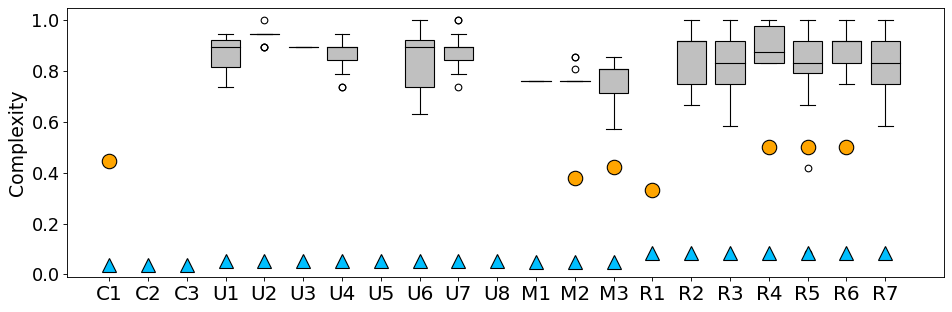

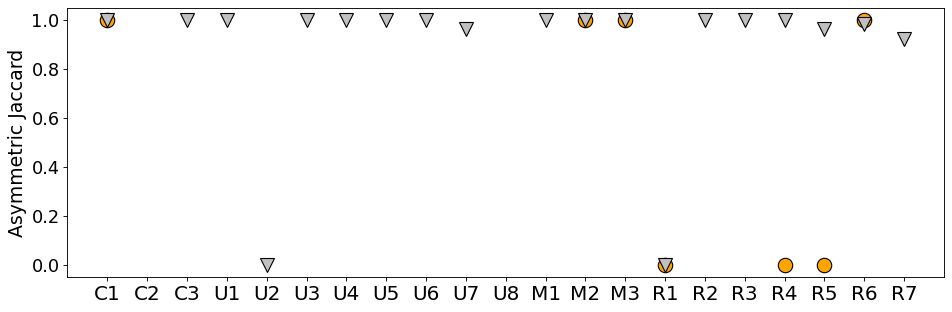

AJ Results - Artificial faults
HPO, Random:  0.90, 0.29
AutoTrainer:  0.61, 0.49


In [95]:
import json
with open('/home/hpo/data/id_map.json', 'r') as f:
    id_map = json.load(f)

### Complexity
# fig, ax = plt.subplots(figsize=(18, 5))
figure(figsize=(12, 4), dpi=80)

x = 0
w = 0.33
width = 0.25

xticks_name, xticks = [], []
i = 0


for _i, pnum in enumerate(sorted(complexities_initial.keys())):
    merge = []
    for time in [20]:
        for algo in algos:
            if (pnum, time, algo) in is_wilc:
                # if id_map[pnum] == "C1":
                #     print(time, algo, complexities_initial[pnum][time][algo])
                merge += complexities_initial[pnum][time][algo]
    if len(merge) == 0:
        pass    
    else:
        # print(pnum, time)
        bp = plt.boxplot([merge], positions=[x+w*i], widths=width, notch=False, vert=True, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor("silver")
        for median in bp['medians']:
            median.set_color('black')
            
    merge = []
    for time in [20]:
        if (pnum, time, "at") in is_wilc:        
            # print(pnum, time)        
            merge += complexities_initial[pnum][time]["at"]
    if len(merge) == 0:
        pass    
    else:
        # bp = plt.boxplot([merge], positions=[x+w*i], widths=width, notch=False, vert=True, patch_artist=True)
        # for patch in bp['boxes']:
        #     patch.set_facecolor("orange")
        # print(pnum, time, complexities_initial[pnum][time]["at"])
        # print(pnum, time, "at")
        plt.plot(x+w*i, np.mean(merge), "o", color="orange", markeredgecolor= "black", markersize=13)        
        
    merge = []
    for time in [20]:
        for algo in algos:
            merge += complexities_initial_gt[pnum][time][algo]
    if len(merge) == 0:
        pass    
    else:                
        plt.plot(x+w*i, np.mean(merge), "^", color="deepskyblue", markeredgecolor= "black", markersize=13)

    xticks.append(x + w*i)
    xticks_name.append(id_map[pnum])
    i += 1

plt.xticks(xticks, xticks_name, fontsize=18)

plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)

plt.ylabel("Complexity", fontsize=17)
# plt.title(f"Complexity (Candidate patches vs. Initial params)", fontsize=14)
plt.tight_layout()
plt.savefig(f'/home/hpo/figures/complexity_deepcrime.pdf')
plt.show()



### Jaccard
figure(figsize=(12, 4), dpi=80)

x = 0
w = 0.33
width = 0.25
i = 0
at_aj = []
hpo_aj = []
for _i, pnum in enumerate(sorted(jaccard_gt.keys())):
    merge = []
    for time in times:
        if (pnum, time, "at") in is_wilc:
            merge += jaccard_gt[pnum][time]["at"]
                
    if len(merge) == 0:
        pass    
    else:
        # bp = plt.boxplot([merge], positions=[x+w*i], widths=width, notch=False, vert=True, patch_artist=True)
        # for patch in bp['boxes']:
        #     patch.set_facecolor("red")
        plt.plot(x+w*i, np.mean(merge), "o", color="orange", markeredgecolor= "black", markersize=13)        
        # print(pnum, "at", np.mean(merge))
        at_aj += merge

    merge = []
    for time in times:
        for algo in algos:
            if (pnum, time, algo) in is_wilc:
                merge += jaccard_gt[pnum][time][algo]
                
    if len(merge) == 0:
        pass    
    else:
        # bp = plt.boxplot([merge], positions=[x+w*i], widths=width, notch=False, vert=True, patch_artist=True)
        plt.plot(x+w*i, np.mean(merge), "v", color="silver", markeredgecolor= "black", markersize=13)        
        # for patch in bp['boxes']:
        #     patch.set_facecolor("silver")        
        # print(pnum, "HPO/Random", np.mean(merge))
        hpo_aj += merge
    i += 1


plt.xticks(xticks, xticks_name, fontsize=18)

plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)

plt.ylabel("Asymmetric Jaccard", fontsize=17)
# plt.title(f"Jaccard", fontsize=14)
plt.tight_layout()
plt.savefig(f'/home/hpo/figures/AJ_deepcrime.png')
plt.show()

print("AJ Results - Artificial faults")
print("HPO, Random: ", f"{np.mean(hpo_aj):.2f}, {np.std(hpo_aj):.2f}")
print("AutoTrainer: ", f"{np.mean(at_aj):.2f}, {np.std(at_aj):.2f}")


